In [1]:
from skimage.transform import pyramid_gaussian
from skimage.draw import rectangle_perimeter
from skimage.util import view_as_windows
from skimage.io import imread, imshow
from skimage.feature import hog
import numpy as np
import pickle
import os

In [2]:
def loadModel(path=""):
    """
    Load persisted model
    """
    with open(path+'modelPkl' , 'rb') as files:
        model = pickle.load(files)
    return model

In [3]:
def loadImgs(srcPath):
    """
    Returns:
        - images (List): List of rgb images
    """
    images = []
    for filename in os.listdir(srcPath):
        img = imread(os.path.join(srcPath, filename))
        images.append(img)

    
    return images

In [4]:
def buildPyramid(img, scale=2):
    """
    Returns:
        - imgs(generator): pyramid of images
    """
    # rows, cols, dim = img.shape
    pyramid = tuple(pyramid_gaussian(img, downscale=scale, channel_axis=-1))
    return pyramid

In [5]:
def getWindows(pymImg,shape=(128,64,3)):
    windows = view_as_windows(pymImg, shape, step=(32,16,3))
    return windows

In [6]:
def HOG(img):
    # imshow(img)
    hogImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
        block_norm='L2', feature_vector=True, channel_axis=-1) # feature vector= true, channel_Axis=2
    return hogImg


In [7]:
def predictPed(img):
    """
    Returns:
        - detection (Bool)
    """
    model = loadModel()
    ans = model.predict(img.reshape(1, -1))
    score = model.predict_proba(img.reshape(1, -1))
    return ans, score

In [20]:
def nms_score(candidates, overlap_threshold=0.1, debug=False):
    if len(candidates) < 3:
        return candidates
    
    if candidates.dtype.kind == "i":
        candidates = candidates.astype("float")
        
    x1 = candidates[:,0]
    y1 = candidates[:,1]
    x2 = candidates[:,2]
    y2 = candidates[:,3]

 	# compute the area of the bounding boxes w*h
    boxArea = (candidates[:,2]-candidates[:,0])*(candidates[:,3]-candidates[:,1])
    index = np.argsort(y2)
    print(f'index: {index}')
    selected = []
    while len(index) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(index) - 1
        lastIndex = index[last]
        # print(f'lastIndex: {lastIndex}')
        #selected.append(lastIndex)
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[lastIndex], x1[index[:last]])
        yy1 = np.maximum(y1[lastIndex], y1[index[:last]])
        xx2 = np.minimum(x2[lastIndex], x2[index[:last]])
        yy2 = np.minimum(y2[lastIndex], y2[index[:last]])
        
        
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)    
  
  		# compute the ratio of overlap
        overlap = (w * h) / boxArea[index[:last]]
        
        if debug:
            print(f'overlap: {overlap}')

        maxScore = np.argmax(candidates[index[np.concatenate(([last],np.where(overlap > overlap_threshold)[0]))],4])
        
        if debug:
            print(f'SCR:{candidates[index[maxScore]]}')

        selected.append(index[maxScore])
        
        # delete all indexes from the index list that have been tested
        index = np.delete(index, np.concatenate(([last],np.where(overlap > overlap_threshold)[0])))
        
    return candidates[selected].astype("int")

In [9]:
def scaleCoords(x,y, level, f):
    
    x = (int(x*(f**(level-1))))
    y = (int(y*(f**(level-1))))
    
    return x, y
# scale_coords(xy_5,level,f)

In [10]:
def getCoords(row,col,level):
    if level != 0: 
        row,col = scaleCoords(row,col,level, 2)
    
    start = ((31 * row), (15 * col))
    end = (((128 * (level+1)) + (31 * row)), ((64 * (level+1)) + (15 * col)))
    return start, end

In [11]:
def drawBox(img, coords):
    newImg = img.copy()

    start, end = (coords[0],coords[1]), (coords[2], coords[3])
    
    rr, cc = rectangle_perimeter(start, end, clip=True, shape=img.shape)
    newImg[rr,cc] = [0,255,0]
    newImg[rr+1,cc+1] = [0,255,0]
    newImg[rr-1,cc-1] = [0,255,0]

    return newImg

In [26]:
def runDetector(img):
    """
    """
    complete = []
    # all1 = np.zeros()
    all1 = []

    # for img in imgs: 
    pyramid = buildPyramid(img)
    for level, pymImg in enumerate(pyramid):
        print(level)
        if pymImg.shape >= (128,64,3):
            window = getWindows(pymImg,(128,64,3))
            rows,cols = window.shape[0], window.shape[1]
            for row in range(rows):
                for col in range(cols):
                    hogWindow = HOG(window[row,col,0])
                    ans, score = predictPed(hogWindow)
                    # print(ans, score[0][int(ans)],int(ans))
                    if ans == 1:
                        accScore = score[0][int(ans)]
                        start, end = getCoords(row,col,level)
                        all1.append([start[0],start[1],end[0],end[1],accScore])
                        img2 = drawBox(img, (start[0],start[1],end[0],end[1]))
        else: 
            break
    
    # applicar NMS
    # necesito coordenada start, end y score
    print(len(all1))
    all1 = np.array(all1)
    selected = nms_score(all1)
    print(selected.shape)
    for i in selected:
        img3 = drawBox(img,i)

    return complete, img2, img3


In [13]:
img = imread(os.path.join("Central_Park,_NYC_(May_2014)_-_23.JPG"))

In [28]:
x, img2, img3 = runDetector(img)
print(x,end="\n")

0
1
2
3
4
5
386
(165, 5)
[]


In [ ]:
imshow(img)

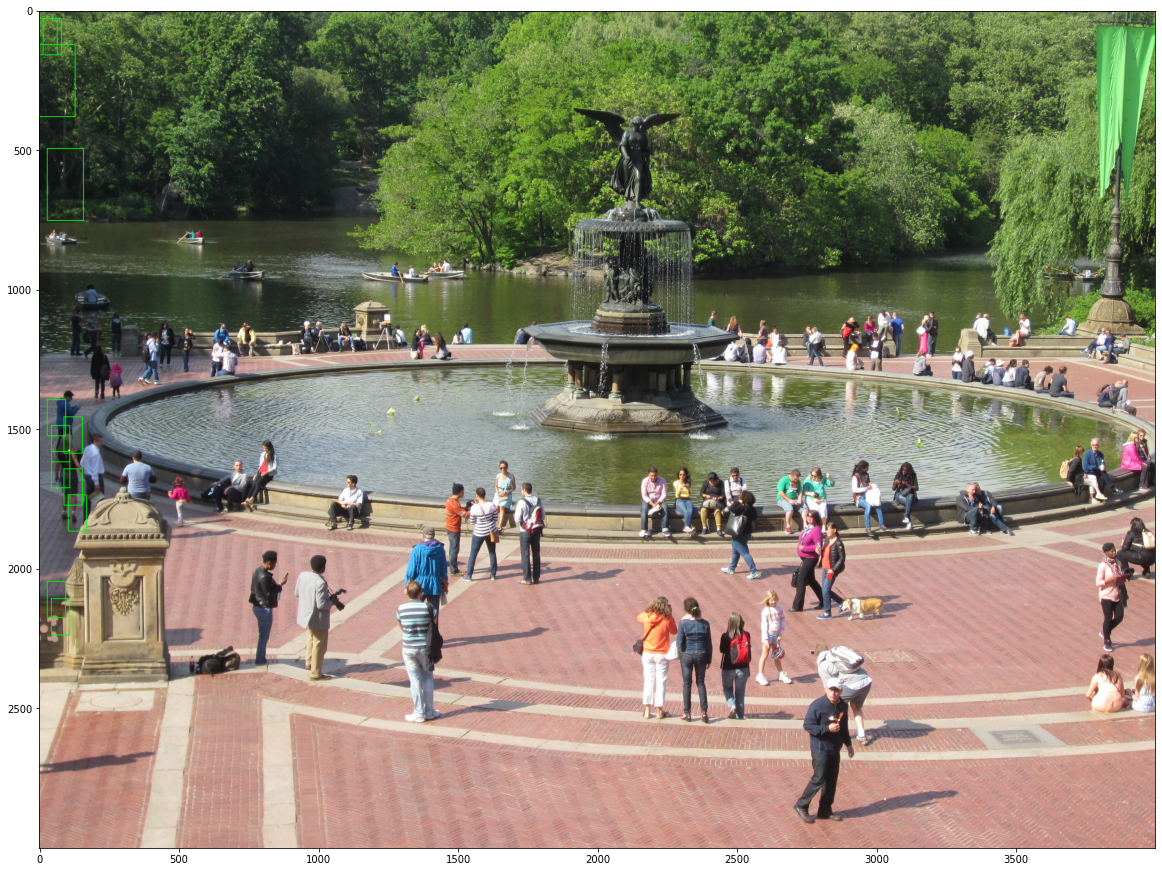

In [19]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(img)
plt.show()

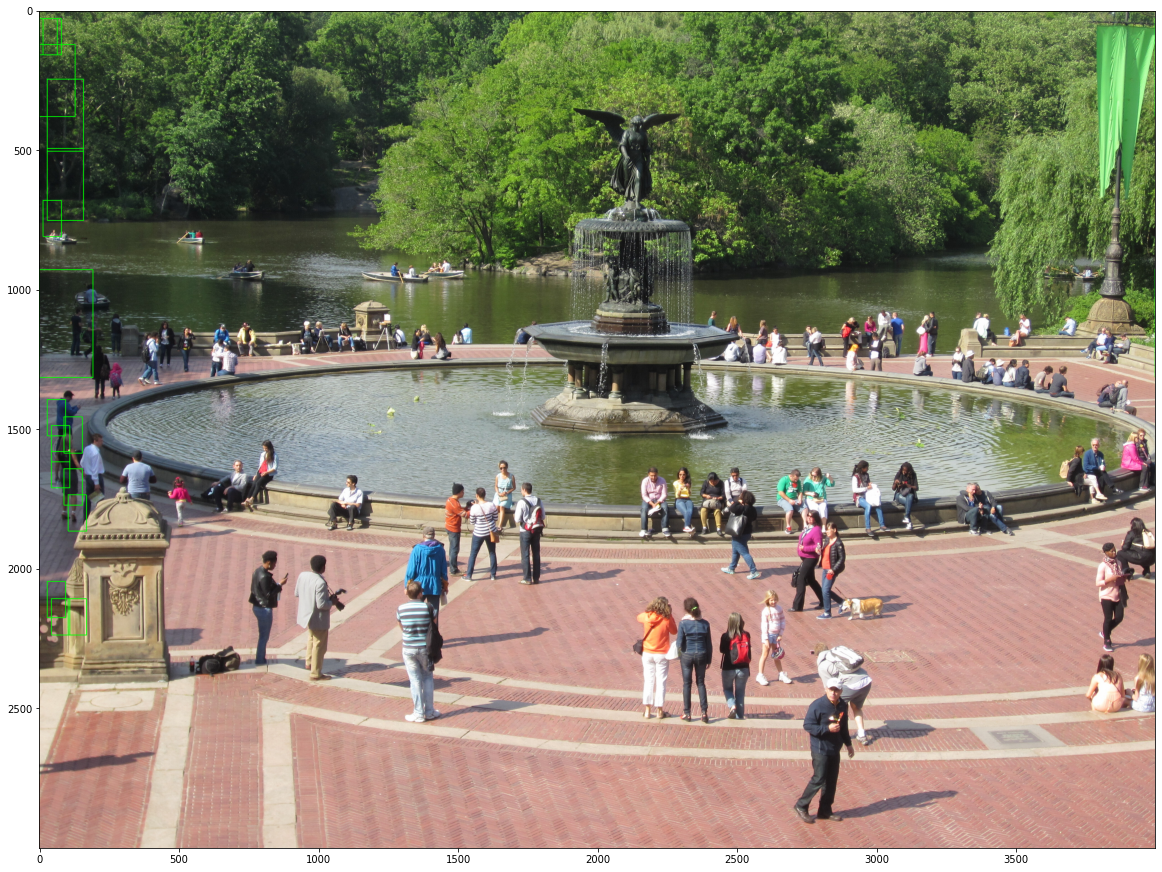

In [29]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(img)
plt.show()

In [ ]:
img2 = drawBox(img, (3,1,0))

In [ ]:
window = getWindows(img,(128,64,3))
imshow(window[3][1][0])
# window.shape

In [ ]:
row, col, level = (1,2,3)
row